# Extractor de características con OpenCV
```
Guillermo Molins
```

En este ejercicio de procesamiento de imágenes, nos enfocaremos en la clasificación binaria de dos razas de gatos: British Shorthair y Egyptian Mau. El objetivo principal es desarrollar un modelo de aprendizaje automático capaz de distinguir entre estas dos razas basándose en características visuales extraídas de imágenes.

Los gatos de la raza British Shorthair son conocidos por su pelaje denso y corto, sus caras redondeadas y ojos grandes y expresivos. Por otro lado, los gatos de la raza Egyptian Mau se destacan por su figura esbelta, pelaje moteado y patas traseras ligeramente más largas que las delanteras. A pesar de estas diferencias visibles, la tarea de clasificación puede ser un desafío debido a variaciones en iluminación, postura y calidad de las imágenes.

In [12]:
import cv2
import matplotlib.pylab as plt
import numpy as np

Como primer paso, guardamos las rutas a las imágenes para hacer la clasificación

In [13]:
from glob import glob

cats_type1 = glob('images/British_Shorthair_*.jpg')
cats_type2 = glob('images/Egyptian_Mau_*.jpg')
print(f'Samples for British Shorthair: {len(cats_type1)}')
print(f'Samples for Egyptian Mau: {len(cats_type2)}')

Samples for British Shorthair: 200
Samples for Egyptian Mau: 200


Contamos con 200 muestras para cada categoría

Creamos una función para poder visualizar las imágenes cómodamente

In [14]:
def print_image(img, axis = 'off', color_map=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap=color_map)
    ax.axis(axis)
    plt.show()

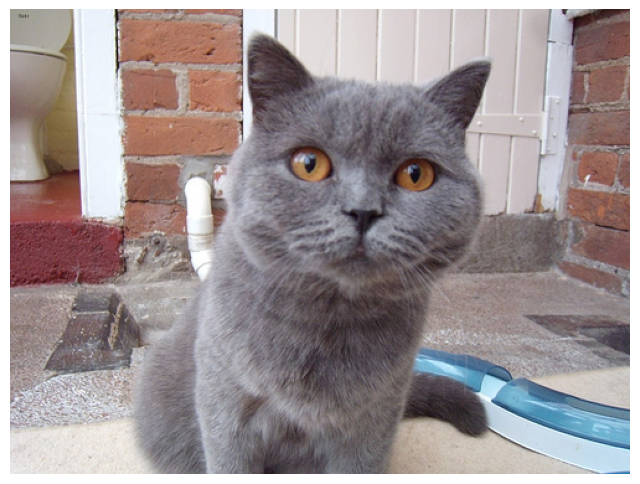

In [15]:
imagen_rgb = cv2.cvtColor(cv2.imread(cats_type1[20]), cv2.COLOR_BGR2RGB)
print_image(imagen_rgb)

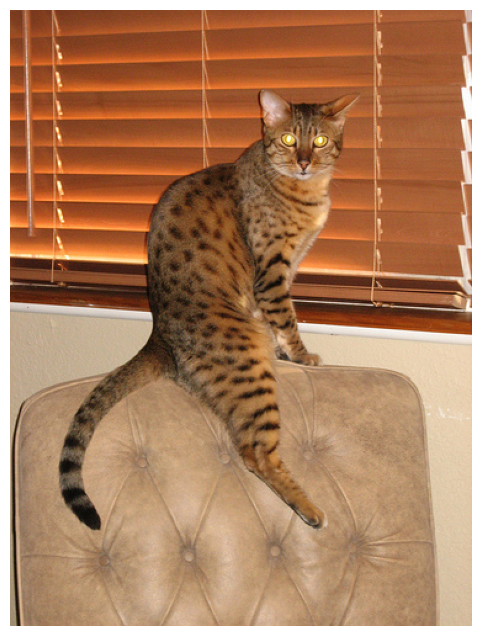

In [16]:
imagen_rgb2 = cv2.cvtColor(cv2.imread(cats_type2[20]), cv2.COLOR_BGR2RGB)
print_image(imagen_rgb2)

Para poder identificar de forma única las distintas especies de gatos, trataremos de extraer características de las imágenes a partir de la transformada de Fourier. El razonamiento siendo que los patrones en el pelaje del Egyptian Mau deberían generar diferencias suficientemente significativas en contraste con los colores lisos (sin patrones) del British Shorthair dentro de nuestros vectores del espectro de magnitud.

In [17]:
def compute_fourier_transform(img):
    if img.dtype != np.float32:
        img = img.astype(np.float32)
    
    # Compute the Discrete Fourier Transform (DFT)
    dft = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)
    
    # Shift the zero-frequency component to the center of the spectrum
    dft_shift = np.fft.fftshift(dft)
    
    # Compute the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])

    # Apply logarithmic scale to improve visibility
    magnitude_spectrum = 20 * np.log(magnitude_spectrum + 1)
    return magnitude_spectrum

<Figure size 800x800 with 0 Axes>

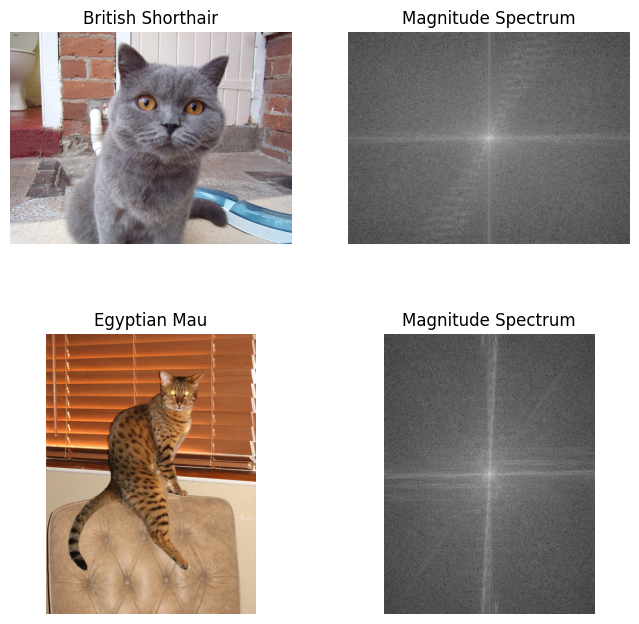

In [18]:
# Read some sample images
british_grey = cv2.imread(cats_type1[20], cv2.IMREAD_GRAYSCALE)
egyptian_mau = cv2.imread(cats_type2[20], cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 8))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Original Image
axs[0, 0].imshow(cv2.cvtColor(cv2.imread(cats_type1[20]), cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('British Shorthair')
axs[0, 0].axis('off')

axs[1, 0].imshow(cv2.cvtColor(cv2.imread(cats_type2[20]), cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Egyptian Mau')
axs[1, 0].axis('off')

# Fourier Transform
axs[0, 1].imshow(compute_fourier_transform(british_grey), cmap='gray')
axs[0, 1].set_title('Magnitude Spectrum')
axs[0, 1].axis('off')

axs[1, 1].imshow(compute_fourier_transform(egyptian_mau), cmap='gray')
axs[1, 1].set_title('Magnitude Spectrum')
axs[1, 1].axis('off')

plt.show()

Como primer paso, creamos una función para la carga y preprocesamiento de las imágenes. Deberemos asegurar que las imagenes tienen una resolución fija para poder alimentar nuestro modelo con los vectores del espectro de magnitud resultantes

In [19]:
def load_and_resize_images(img_list, image_size=(256, 256)):
    images = []
    for filename in img_list:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to load image {filename}")
        else:
            img_resized = cv2.resize(img, image_size)
            images.append(img_resized)
    return images

def extract_features(images):
    features = []
    for img in images:
        magnitude_spectrum = compute_fourier_transform(img)
        features.append(magnitude_spectrum.flatten())
    return features

Algunas imágenes no cargan correctamente, por lo que incluimos una condición en ```cv2.imgread()``` para omitirlas

In [20]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load images
class1_images = load_and_resize_images(cats_type1)
class2_images = load_and_resize_images(cats_type2)

# Create labels
class1_labels = [0] * len(class1_images)
class2_labels = [1] * len(class2_images)

# Extract features
class1_features = extract_features(class1_images)
class2_features = extract_features(class2_images)

# Combine data and labels
X = np.array(class1_features + class2_features)
y = np.array(class1_labels + class2_labels)

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 77.22%


In [25]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred2 = rfc.predict(X_test)
accuracy2 = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy2 * 100:.2f}%')

Accuracy: 77.22%


Como referencia, obtenemos el mismo resultado utilizando un Random Forest Classifier

In [26]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.84810127, 0.7721519 , 0.72151899, 0.78481013, 0.82278481])

In [27]:
np.std(scores)

0.043556077301481665

Como comprobación adicional, aplicamos cross-validation. Esto nos brinda resultados concluyentes sobre el rendimiento de nuestro modelo, que en lineas generales opera de forma homogenea en todo el dataset

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        49
           1       0.69      0.73      0.71        30

    accuracy                           0.77        79
   macro avg       0.76      0.76      0.76        79
weighted avg       0.78      0.77      0.77        79



Algunas de las imágenes no cargan correctamente (5 de 400) y esto crea un pequeño desbalance en nuestro dataset. Sin embargo, no son suficientes como para condicionar de forma significativa el resultado de nuestro modelo. La precisión obtenida es modesta pero adecuada para el procesamiento relativamente sencillo que estamos haciendo sobre las imágenes.

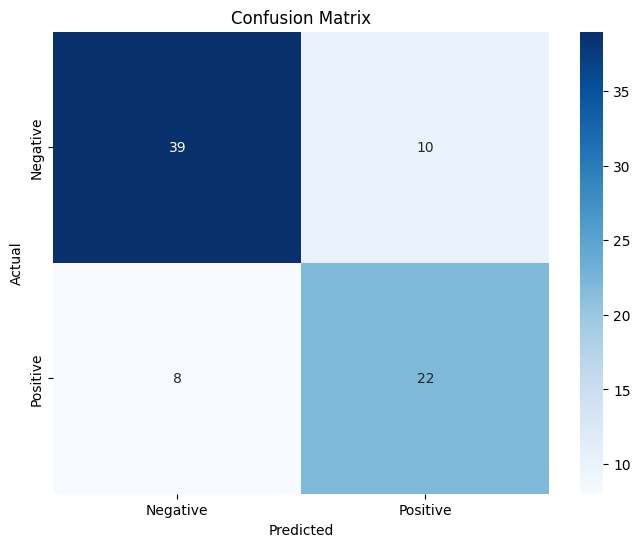

In [22]:
# Plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

El error en nuestro modelo parece estar balanceado

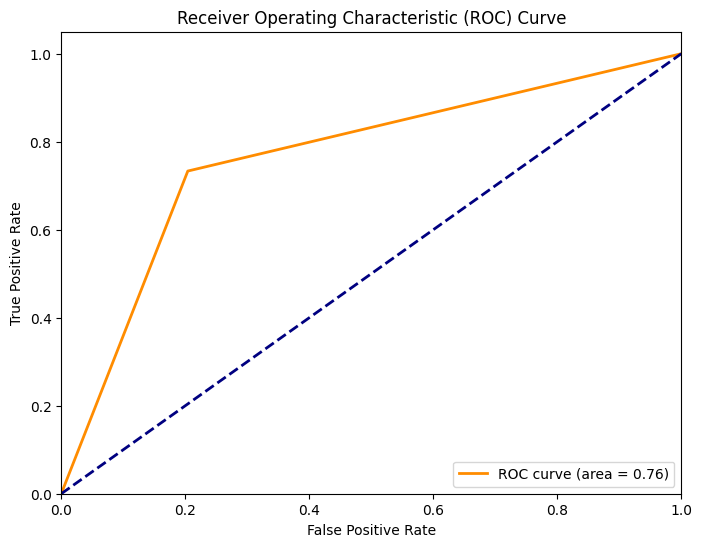

In [23]:
# Plot ROC curve
from sklearn.metrics import auc, roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

En conclusión, el análisis de frecuencias por medio de la transformada de Fourier es un método relativamente efectivo para extraer características que nos permitan discernir estas dos razas de gato. Algunas mejoras que se prodrían aplicar al modelo incluyen:

1. Preprocesamiento de Imágenes

    * **Ecualización de Histograma:** Mejorar el contraste de las imágenes.
    * **Data Agumentation:** Aplicar transformaciones aleatorias (por ejemplo, rotaciones o traslaciones) par aumentar la diversidad de los datos de entrenamiento.

2. Extracción Avanzada de Características

    * **Características Adicionales:** Combinar características de la Transformada de Fourier con otras características como detectores de bordes (por ejemplo, filtros de Sobel), características de textura (por ejemplo, filtros de Gabor), o intensidades de píxeles.

3. Selección y Ajuste del Modelo

    * **Clasificadores Avanzados:** Utilizar otros clasificadores como Gradient Boost (por ejemplo, XGBoost, LightGBM) o Redes Neuronales.
    * **Ajuste de Hiperparámetros:** Utilizar técnicas como Grid Search para encontrar los hiperparámetros óptimos para el modelo.

4. Métodos tipo Ensemble Learning

    * Combinar predicciones de múltiples modelos para mejorar la robustez y el rendimiento.